In [1]:
import glob 
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

mpl.rc('text', usetex=False)
mpl.rcParams['figure.dpi'] = 75

mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20

#Set the typography that you want to use
mpl.rcParams['font.family'] = 'Arial'

# Set colors in order of comparison, all matplotlib colors are available 
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["blue", "red", "purple", 
                                                    "orange", "royalblue", "limegreen", 
                                                    "blueviolet","darkorange", "tomato"])  

# Two particles in a channel: Interactions?

In this script, I will analyze the trajectories of two particles inside a channel. I want to determine if they are interacting or not and if it depends on the distance among particles. The analyzed experiments were performed on 22-02-2022.


In [2]:
def read_trj_and_particles(directory = str, extension = str):
    
    filenames = [file for file in glob.glob(os.path.join(directory,('*'+extension)))]
    
    print(filenames)
    
    trj = [pd.read_csv(file, sep =",",skiprows = [1,2,3], index_col = [0], usecols = [2,4,5,8]) 
           for file in filenames]
    
    keys = [df.index.get_level_values('TRACK_ID').unique().values
            for df in trj]
    
    keys = np.concatenate(keys).ravel().tolist()
    keys = np.arange(0,len(keys))
    print(keys)
    trj = pd.concat(trj, keys = keys)
    trj.index.names = ['exp','id']
    trj.sort_values(by = ['exp','id','FRAME'], inplace = True)
    
    return trj

In [3]:
directory = "/media/Carol/Magnetic/Experiments/Microfluidics_experiments/PDMS_chips/22-02-2023/2-particles"
trj = read_trj_and_particles(directory, '2ul*.csv')

['/media/Carol/Magnetic/Experiments/Microfluidics_experiments/PDMS_chips/22-02-2023/2-particles/2ul-min_2023_02_22_16_52_11-s.csv', '/media/Carol/Magnetic/Experiments/Microfluidics_experiments/PDMS_chips/22-02-2023/2-particles/2ul-min_2023_02_22_16_52_47-n.csv']
[0 1 2 3]


In [4]:
interaction = trj.loc[0]
no_interaction = trj.loc[1]

# Here I will only keep the frames when the two particles are already inside of the channel. 

In [5]:
# <For 2ul-min experiments>

no_interaction = no_interaction.query('FRAME > 180 & FRAME < 392') 
interaction = interaction.query('FRAME > 215 & FRAME < 495')

#<For 1ul-min experiments>

# no_interaction = no_interaction.query('FRAME > 418 & FRAME < 875') 
# interaction = interaction.query('FRAME > 423 & FRAME < 1268')

# <For 2,5ul-min experiments>

# no_interaction = no_interaction.query('FRAME > 180 & FRAME < 335') 
# interaction = interaction.query('FRAME > 152 & FRAME < 391')

# # <For 4ul-min experiments>

# no_interaction = no_interaction.query('FRAME > 149 & FRAME < 280') 
# interaction = interaction.query('FRAME > 93 & FRAME < 252')

In [6]:
def define_t_entrance(df, frame_rate = float):
    """With this function, we want to generate the correspndence of t=0 
    to the time when the two particles are inside of the channel.
    The idea is to be consistent in time in all the analysis: 
    distance, velocity and velocity_CM"""
    df['t'] = (df['FRAME'] - df['FRAME'].min())*frame_rate
    return df

In [7]:
interaction = define_t_entrance(interaction, 1/30)
no_interaction = define_t_entrance(no_interaction, 1/30)

In [8]:
def d(df , pix = float, um = float):  
    "With this function I will compute the distance among particles."
    
    inter = df[df.duplicated(subset=['FRAME'], keep=False)] # Keep only frames with 2 particles.
    inter = inter.reset_index()
    inter = inter.set_index(['id','FRAME']) # reset index
    
    dx = []
    dy = []
    frame = []
    grouped = inter.groupby(['FRAME'])
    for name,group in grouped:
        
        dx.append((np.sqrt((group.POSITION_X.diff(periods=-1).values)**2)[0])*(um/pix))
        dy.append((np.sqrt((group.POSITION_Y.diff(periods=-1).values)**2)[0])*(um/pix))

        frame.append(group.t.unique()[-1])
        
    return dx,dy, frame
    

In [9]:
dxi,dyi , f_i = d(interaction, pix = 497.549, um = 1000)
dxn,dyn, f_n = d(no_interaction, pix = 497.549, um = 1000)

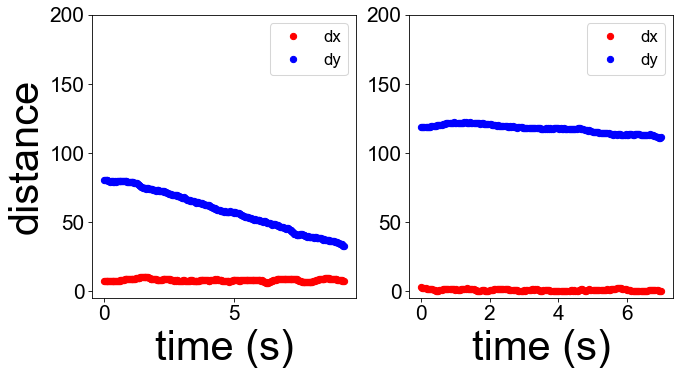

In [10]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].plot(f_i, dxi, 'o', label = 'dx', c = 'r')
ax[0].plot(f_i, dyi, 'o', label = 'dy', c = 'b')

ax[1].plot(f_n, dxn, 'o', label = 'dx', c = 'r')
ax[1].plot(f_n, dyn, 'o', label = 'dy', c = 'b')



ax[0].set_xlabel('time (s)', size = 40)
ax[1].set_xlabel('time (s)', size = 40)
ax[0].set_ylim(-5,200)
ax[1].set_ylim(-5,200)
ax[0].set_ylabel('distance', size = 40)
ax[0].legend(fontsize = 16)
ax[1].legend(fontsize = 16)

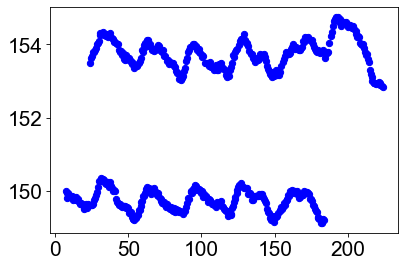

In [17]:
plt.plot(interaction.POSITION_Y, interaction.POSITION_X, 'o')

In [28]:
def v_and_v_cm(df, frame_rate = float , pix = float, um = float):

    inter = df[df.duplicated(subset=['FRAME'], keep=False)] # Keep only frames with 2 particles.
    inter = inter.reset_index()
    inter = inter.set_index(['id','FRAME']) # reset index

    ids = inter.index.get_level_values('id').unique()
    delta_r = []
    
    # Measure the displacement of the particle among consecutive frames. 

    for i in ids:
        print(i)
        dp = inter.loc[i].copy(deep= True)
        delta_r.append(0)

        for i in range(0,len(dp)-1):
            j = i+1  
            delta_r.append((np.sqrt((dp.iloc[j].POSITION_X-dp.iloc[i].POSITION_X)**2+(dp.iloc[j].POSITION_Y-dp.iloc[i].POSITION_Y)**2))**(um/pix))


    inter['y'] = inter['POSITION_Y'] # um/pix from scale bar
    inter['delta_r'] = delta_r
    inter['delta_t'] = 1/30 # 30 fps
    inter['v'] = (inter['delta_r'])/inter['delta_t'] # um/pix from scale bar

    # From here, I will compute the velocity of the center of mass.

    inter.sort_values(by = ['FRAME'], inplace = True)
    v_cm = []
    t = []
    for ind, group in inter.groupby('FRAME'):
        v_cm.append((group.v.sum())/2)
        t.append(group.t.unique()[-1])

    return inter, v_cm, t


In [29]:
no_inter, v_cm_n, t_n = v_and_v_cm(no_interaction, pix = 497.549, um = 1000)
interac, v_cm, t = v_and_v_cm(interaction,pix = 497.549, um = 1000)

1
2
1
4


In [30]:
no_inter.to_csv('v_particles_vs_time_Q2ml-min.dat', sep = '\t')
interac.to_csv('v_particles_inter_vs_time_Q2ml-min.dat', sep = '\t')

In [32]:
v_CM_n = {'v(um/s)': v_cm_n , 't(s)': t_n}
v_CM = {'v(um/s)' : v_cm, 't(s)': t}

df = pd.DataFrame(data=v_CM_n)
df_n = pd.DataFrame(data=v_CM)


#df.to_csv('velocityCM-interaction_Q2ul-min.dat', sep = '\t')
#df_n.to_csv('velocityCM-Nointeraction_Q2ul-min.dat', sep = '\t')

In [33]:
d_i = {'d_inter(um)': d_i , 't_inter(s)': f_i}
d_n = {'d_Ninter(um)' : d_n, 't_Ninter(s)': f_n}

df = pd.DataFrame(data=d_i)
df_n = pd.DataFrame(data=d_n)


#df.to_csv('distance-interaction_Q2ul-min.dat', sep = '\t')
#df_n.to_csv('distance-Nointeraction_Q2ul-min.dat', sep = '\t')

NameError: name 'd_i' is not defined

NameError: name 'd_i' is not defined

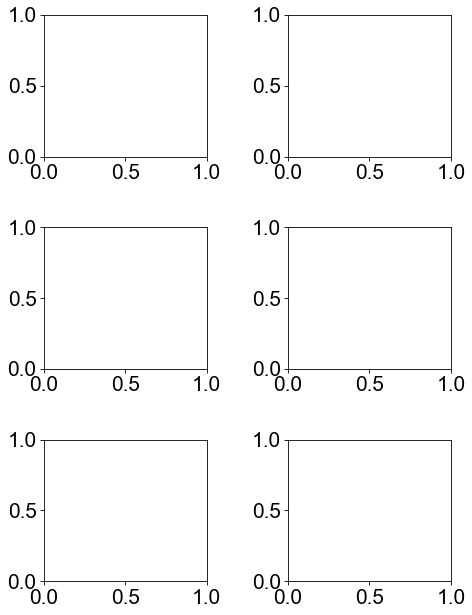

In [34]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 2, figsize = (7,10))

fig.subplots_adjust(wspace=0.5)
fig.subplots_adjust(hspace=0.5)


ax0[1].plot(f_i, d_i, 'o')
ax0[0].plot(f_n, d_n, 'o')

ax0[0].set_ylabel(r'$distance  (\mu m)$', size = 20)
ax0[0].set_xlabel(r'time (s)', size = 20)
ax0[1].set_xlabel(r'time (s)', size = 20)


ax0[0].set_title('No interaction', size = 20)
ax0[1].set_title('Interaction', size = 20)
ax0[0].set_ylim(100,200)
ax0[1].set_ylim(0,70)

for ind, group in no_inter.groupby('id'):
    
    ax1[0].plot(group.y, group.v, '-', label = 'particle'+str(ind))
    ax1[0].legend()
    ax1[0].set_ylabel(r'$v  (\mu m/s)$', size = 20)
    ax1[0].set_xlabel(r'$y  (\mu m)$', size = 20)
    
    
for ind, group in interac.groupby('id'):
    
    ax1[1].plot(group.y, group.v, '-', label = 'particle'+str(ind))
    ax1[1].legend()
    ax1[1].set_xlabel(r'$y  (\mu m)$', size = 20)
    
ax2[0].plot(t_n, v_cm_n, '-')
ax2[1].plot(t, v_cm, '-')
ax2[0].set_ylabel(r'$v_{CM}  (\mu m/s)$', size = 20)
ax2[0].set_xlabel(r'$time (s)$', size = 20)
ax2[1].set_xlabel(r'$time (s)$', size = 20)


ax1[0].set_ylim(-10, 90)
ax1[1].set_ylim(-10, 90)

ax2[0].set_ylim(0, 80)
ax2[1].set_ylim(0, 80)

#plt.savefig('TwoParticlesInChannel_4ul-min.png', bbox_inches='tight')